# Generating stream networks for USGS Hydrologic Modeling software

This notebook builds on the preceeding notebooks ("Generating meshes", "Hydrologic conditioning", and "Flow Accumulation / Directions") to demonstrate how to use the `D-Any` package for generating stream networks that can be used for creating models. Models that are currently supported include:
   - `MODFLOW-6`: SFR package is supported
   - `MODFLOW-2005/NWt`: SFR package is supported
   - `PRMS`: Stream network generation and cascade routing is supported
   - `GSFLOW`: Combines the functionality and support for PRMS and MODFLOW-NWT

This notebook starts with raster and shapefile (vector) data and builds stream networks that can be used with each of the listed model types. 

*Note*: Even though this notebook focuses on a `VertexGrid` example, the same `D-Any` classes and functions can be used with `StructuredGrid` (rectilinear grids) and `UnstructuredGrid` instances.

In [1]:
import dany
import flopy
import gsflow
import numpy as np
import geopandas as gpd
import pathlib as pl
import matplotlib.pyplot as plt

from dataretrieval import nwis, nldi
from pyproj import Transformer

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

## Load the study area raster
This example uses built in functionality from the `FloPy` and `dataretrieval` packages to set up the model's mesh. For more information about this process, see the "Generating Meshes" notebooks

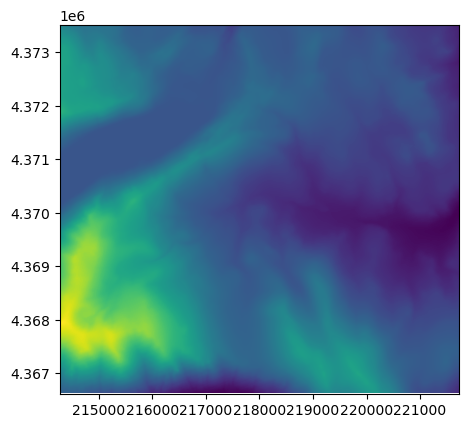

In [2]:
raster = pl.Path("../data/dem.img")
rstr = flopy.utils.Raster.load(raster)
rstr.plot();

### Pull a watershed boundary from USGS National-Linked Data Index (NLDI)

The `dataretreival` package can be used to 1) get streamgage data locations and flows, and 2) pull upstream catchment boundaries based on streamgage locations.

This example gets the stream and lake gages for our area of interest and we use USGS streamgage 10343500 to define the watershed outlet

To begin this work, first Define coordinate reference systems (CRS) for the raster and the data pull and then create a transformer to convert between the two CRS instances.

In [3]:
epsg_utm = rstr.crs.to_epsg()
epsg_wgs84 = 4326  # decimal lat lon
crs_utm = f"EPSG:{epsg_utm}"
crs_wgs84 = f"EPSG:{epsg_wgs84}"

transformer = Transformer.from_crs(crs_utm, crs_wgs84, always_xy=True)

get decimal latitude longitude boundaries for the area of interest

In [4]:
xmin, xmax, ymin, ymax = rstr.bounds
xmin, ymin = transformer.transform(xmin, ymin)
xmax, ymax = transformer.transform(xmax, ymax)
wgs_bounds = [xmin, ymin, xmax, ymax]

get streamgage station locations

In [5]:
info, meta = nwis.get_info(bBox=[f"{i :.2f}" for i in wgs_bounds])
info.to_crs(epsg=epsg_utm, inplace=True)
info.head()

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,10342900,INDEPENDENCE LK NR TRUCKEE CA,LK,392707.0,1201723.00,39.451849,-120.290759,M,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (216838.412 4372090.976)
1,USGS,10343000,INDEPENDENCE C NR TRUCKEE CA,ST,392724.0,1201710.00,39.456572,-120.287148,M,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (217168.338 4372603.864)
2,USGS,10343500,SAGEHEN C NR TRUCKEE CA,ST,392554.0,1201413.00,39.431572,-120.237979,M,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (221299.997 4369675.311)
3,USGS,392501120182800,SAGEHEN CR NR CARPENTER RIDGE CA,ST,392501.0,1201828.00,39.416849,-120.308814,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (215141.782 4368262.355)
4,USGS,392553120142301,NADP NTN CA50 A SAGEHEN CREEK NR TRUCKEE CA,AT,392553.4,1201422.92,39.431500,-120.239700,M,M,...,U,Y,NaN,NaN,NaN,NaN,NaN,NaN,NADP,POINT (221151.573 4369672.591)


Plot up gage locations on the raster

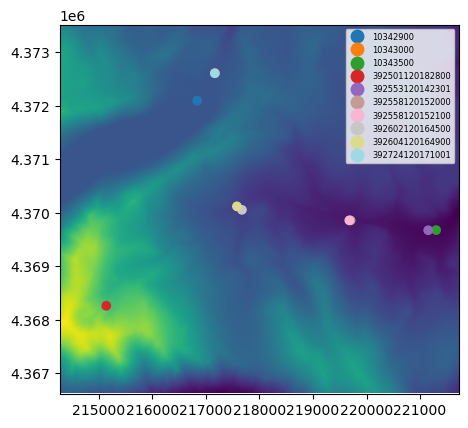

In [6]:
fig, ax = plt.subplots()

raster = pl.Path("../data/dem.img")
rstr = flopy.utils.Raster.load(raster)
rstr.plot(ax=ax)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize":6});

In [7]:
sitedf = info[info.site_no == "10343500"]

get the basin boundary

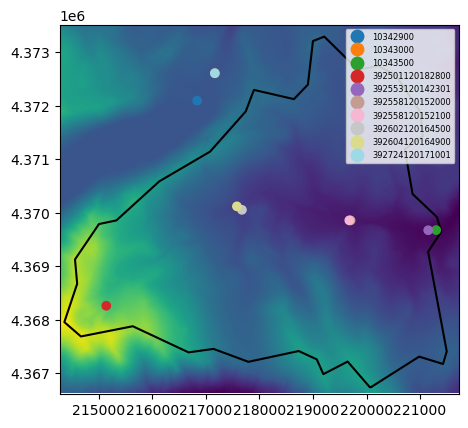

In [8]:
basindf = nldi.get_basin(
    feature_source="nwissite",
    feature_id=f"USGS-{sitedf.site_no.values[0]}"
)
basindf.to_crs(epsg=epsg_utm, inplace=True)

fig, ax = plt.subplots()
rstr.plot(ax=ax)
basindf.plot(ax=ax, facecolor="None", edgecolor="k", lw=1.5)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize":6});

## Generate a Voronoi mesh

This example uses the basin boundary that was downloaded from NLDI to generate a Voronoi mesh

Begin by creating a triangular mesh

In [9]:
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid

ws = pl.Path("./strm_network_tri")
ws.mkdir(exist_ok=True)

tri = Triangle(angle=30, model_ws=ws)
tri.add_polygon(basindf.geometry.values[0])
tri.add_region(basindf.centroid.values[0], 0, maximum_area=4000)
tri.build()

Build the voronoi mesh from the triangulation

In [10]:
vor = VoronoiGrid(tri)
vgrid = flopy.discretization.VertexGrid(nlay=1, **vor.get_gridprops_vertexgrid())

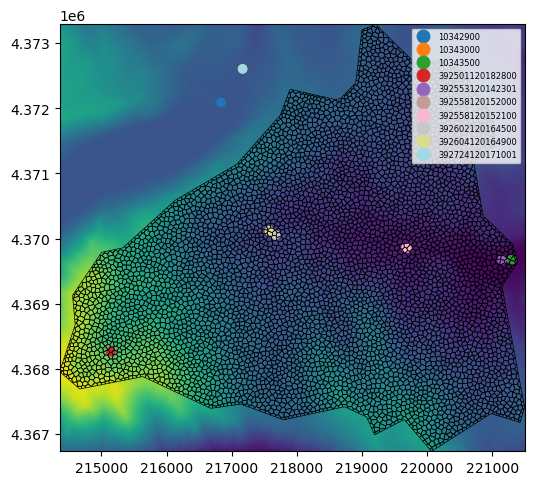

In [11]:
# plot the grid
fig, ax = plt.subplots(figsize=(6, 6))

rstr.plot(ax=ax)
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pmv.plot_grid(color="k", lw=0.5)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize": 6});

### Resample the raster to the Voronoi Mesh

`FloPy`'s raster class has a built in method that can be used for geostatical resampling of rasters to a grid discretization. For digital elevation model (DEM) data, minimum resampling is recommended for later processing with flow accumulation algorithms.

In [12]:
rstr = flopy.utils.Raster.load(raster)
resampled_dem = rstr.resample_to_grid(
    vgrid,
    band=rstr.bands[0],
    method="min"
)

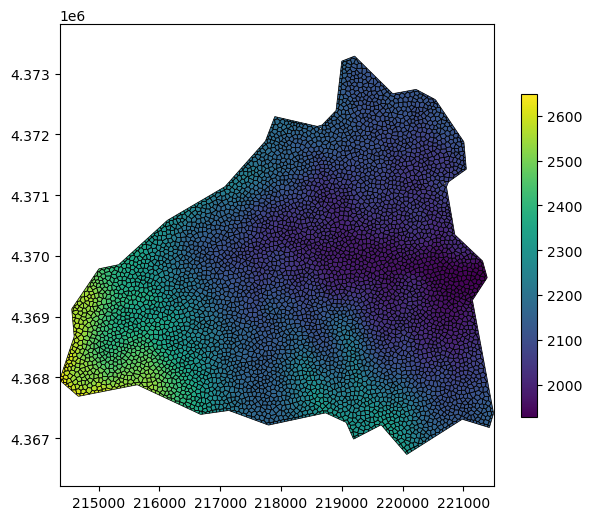

In [13]:
# plot the grid and the resampled dem
fig, ax = plt.subplots(figsize=(7, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(resampled_dem)
pmv.plot_grid(color="k", lw=0.5)
plt.colorbar(pc, shrink=0.7);

### Hydrologic conditioning

Hydrologic conditioning can be done with `dany.fill_sinks()`. This method uses a modified improved-epsilon priority flood sink filling method to condition the digital elevations. More information about this process can be found in the "Hydrologic_conditioning" notebook.

In [14]:
conditioned_dem = dany.fill_sinks(vgrid, resampled_dem)
conditioned_dem = dany.fill_nan_values(vgrid, conditioned_dem)

### Flow directions and flow accumulation

Flow directions and flow accumulation can be calculated using the `dany.FlowDirections` class. This class uses the "D-Any" algorithm to calculate flow directions. For more information on this process, see the "Flow directions and accumulation" notebook. 

In [15]:
fdobj = dany.FlowDirections(vgrid, conditioned_dem)
fdirs = fdobj.flow_directions()
facc = fdobj.flow_accumulation()

# get the flow direction vectors
qx, qy = fdobj.vectors

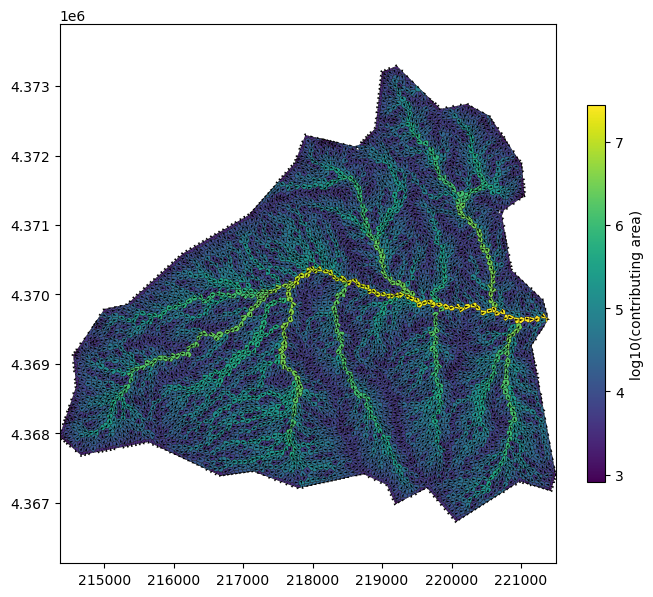

In [16]:
# plot the flow directions and flow accumulation array
fig, ax = plt.subplots(figsize=(8, 7))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(np.log10(facc))
pmv.plot_vector(qx, qy)
pmv.plot_grid(color="k", lw=0.2)
plt.colorbar(pc, shrink=0.7, label="log10(contributing area)");

## Generating stream networks
Once flow directions and flow accumulation has been calculated, stream networks and model inputs can be generated for the following models:
   - MODFLOW-6
   - MODFLOW-2005/NWT
   - PRMS & pywatershed
   - GSFLOW

The `dany` package has class objects for generating stream networks and the specific representations of these networks for each of the listed models. This notebook will show an example of generating inputs for each of these model types

### Generate modflow-6 SFR data

The `dany.Sfr6` class has methods to generate stream networks and produce MODFLOW-6 connection data, and package data that can be used with `FloPy` to generate new SFR packages. The `Sfr6` class has two user supplied inputs:
   - `modelgrid` : a flopy.discretization.grid object that represents the modeling domain
   - `faobj` : a dany.FlowDirections object that can be used to generate streams

In [17]:
sfr6 = dany.Sfr6(vgrid, fdobj)

the `delineate_streams()` method on the `Sfr6` object allows users to threshold stream cells based on an upslope contributing area (in model units ^ 2). `delineate_streams()` accepts one input parameter:
   - `contrib_area`: upslope contributing area threshold. This can either be a single value or an array of values who's shape corresponds to the number of modelgrid nodes.

Try playing with the contrib_area variable to see how the stream network changes based on the thresholding factor.

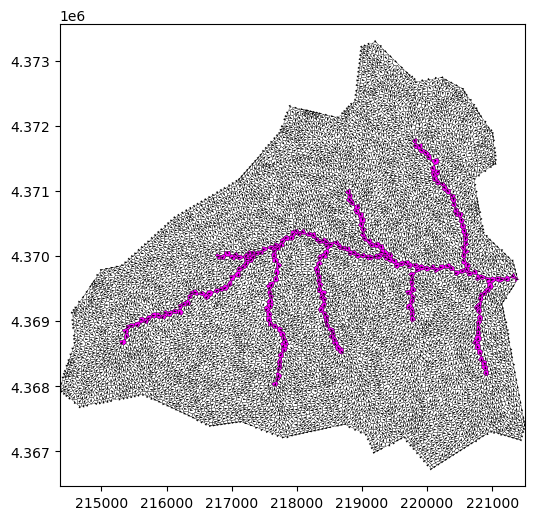

In [18]:
contrib_area = 1e6  # m^2
stream_array = sfr6.delineate_streams(contrib_area)

# plot the flow directions and flow accumulation array
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(stream_array, masked_values=[0], cmap="spring")
pmv.plot_vector(qx, qy)
pmv.plot_grid(color="k", lw=0.2);

Once the stream array has been generated with `delineate_streams` graph networks of stream connectivity can be produced and/or SFR input data can be generated. 

To get an optional graph of stream connectivity, users can call `get_stream_connectivity()`. This method has a single, optional parameter:
   - `stream_array`: optional, numpy array of user supplied, thresholded stream cells. This option is useful for providing custom modifications to the delineated stream network.

The method returns a dictionary of reach connectivity, based on assigned reach numbers in the stream array.

In [19]:
stream_graph = sfr6.get_stream_connectivity()

#### Generate MODFLOW-6 SFR connection data block input

The `connectiondata()` method generates the MODFLOW-6 connection data block inputs based on graph analysis of the stream network. The `connectiondata()` method accepts one optional argument:
   - `graph`: optional, user supplied custom graph network of stream connectivity. If it is not supplied (default) the code produces a topologically sorted network from the thresholded stream array.

In [20]:
connectiondata = sfr6.connectiondata()
connectiondata[0:15]

[(1, -2),
 (2, 1, -3),
 (3, 2, -4),
 (4, 3, -5),
 (5, 4, -6),
 (6, 5, -7),
 (7, 6, -8),
 (8, 7, -9),
 (9, 8, -10),
 (10, 9, -11),
 (11, 10, -12),
 (12, 11, -13),
 (13, 12, -14),
 (14, 13, -15),
 (15, 14, -18)]

#### Generate MODFLOW-6 SFR package data block input

The `packagedata()` method generates the MODFLOW-6 package data block inputs. This method makes some initial assumptions about stream length `rlen` and slope `rwid` and returns a numpy recarray of input parameters that the user can finish filling out to build their SFR package.

In [21]:
packagedata = sfr6.packagedata()
packagedata[0:5]

array([(1, (0, 5233), 109.69454385, 0., 0.02559042, 2080.24121094, 1., 0., 0., 1, 1., 0),
       (2, (0, 4950), 100.18665748, 0., 0.02094723, 2077.43408203, 1., 0., 0., 2, 1., 0),
       (3, (0, 4922), 109.02578711, 0., 0.0504647 , 2075.33544922, 1., 0., 0., 2, 1., 0),
       (4, (0, 4923), 109.02578711, 0., 0.04761632, 2069.83349609, 1., 0., 0., 2, 1., 0),
       (5, (0, 4920), 113.93942336, 0., 0.06138044, 2064.64208984, 1., 0., 0., 2, 1., 0)],
      dtype=[('ifno', '<i4'), ('cellid', 'O'), ('rlen', '<f8'), ('rwid', '<f8'), ('rgrd', '<f8'), ('rtp', '<f8'), ('rbth', '<f8'), ('rhk', '<f8'), ('man', '<f8'), ('ncon', '<i4'), ('ustrf', '<f8'), ('ndv', '<i4')])

### Generate stream connectivity input data for PRMS

The `dany.PrmsStreams` class can be used to generate stream networks and produce PRMS input data including stream parameters and cascades. `dany.PrmsStreams` has two user supplied inputs:
   - `modelgrid` : a flopy.discretization.grid object that represents the modeling domain
   - `faobj` : a dany.FlowDirections object that can be used to generate streams

In [22]:
prms_strms = dany.PrmsStreams(vgrid, fdobj)

the `delineate_streams()` method on the `PrmsStreams` object allows users to threshold stream cells based on an upslope contributing area (in model units ^ 2). `delineate_streams()` accepts one input parameter:
   - `contrib_area`: upslope contributing area threshold. This can either be a single value or an array of values who's shape corresponds to the number of modelgrid nodes.

Try playing with the `contrib_area` variable to see how the stream network changes based on the thresholding factor.

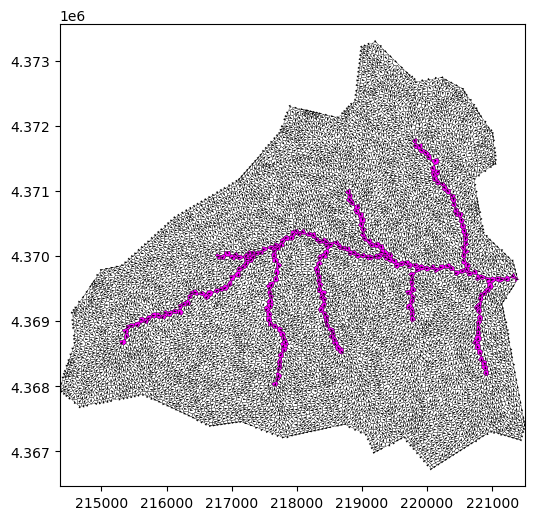

In [23]:
contrib_area = 1e6  # m^2
stream_array = prms_strms.delineate_streams(contrib_area)

# plot the flow directions and flow accumulation array
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(stream_array, masked_values=[0], cmap="spring")
pmv.plot_vector(qx, qy)
pmv.plot_grid(color="k", lw=0.2);

#### Getting cascade information for the watershed

The `get_cascades()` on `PrmsStreams` is used to generate PRMS cascade parameters, such as hru_up_id and hru_down_id. This method can accept any of three optional parameters:
   - `stream_array` : optional user specified numpy array of stream data (0 is not a stream, > 0 is a stream)
   - `basin_boundary`: optional basin boundary array to designate active and inactive PRMS hrus
   - `many2many`: optional boolean flag parameter. False creates many to one cascade routing (many hrus can flow into a single hru, but a single hru can only flow into a single outflow hru). True creates many to may cascade routining. Default is False

`get_cascades` returns four numpy arrays corresponding to the PRMS parameters `hru_up_id`, `hru_down_id`, `hru_pct_up`, `hru_streamseg_down_id`

In [24]:
hru_up_id, hru_down_id, hru_pct_up, hru_strmseg_down_id = prms_strms.get_cascades()
hru_up_id

array([   1,    2,    3, ..., 5675, 3310, 5676])

#### Getting pyGSFLOW compatible cascade information

`D-Any` has built in support for `pygsflow` builder workflows like `gsflow.builder.PrmsBuilder()`. The `get_pygsflow_builder_object()` method can be used to get a `pygsflow` compatible object of cascade routing information. This method has a few optional input parameters including:
   - `stream_array` : optional user specified numpy array of stream data (0 is not a stream, > 0 is a stream)
   - `basin_boundary`: optional basin boundary array to designate active and inactive PRMS hrus
   - `group_segments`: optional boolean flag parameter. Default is True and groups adjacent stream hrus between stream confluences into a single prms segment. False sets each individual stream hru as a unique segment
   - `many2many`: optional boolean flag parameter. False creates many to one cascade routing (many hrus can flow into a single hru, but a single hru can only flow into a single outflow hru). True creates many to may cascade routining. Default is False


In [25]:
pgsf_cascades = prms_strms.get_pygsflow_builder_object(
    group_segments=False,
    many2many=False
)
# inspect the attributes of the cascades object
pgsf_cascades.__dict__

{'dany_flag': True,
 'ncascade': 8848,
 'hru_up_id': array([   1,    2,    3, ..., 5675, 3310, 5676]),
 'hru_down_id': array([1376, 2249, 3544, ..., 5551, 5640, 5640]),
 'hru_pct_up': array([1., 1., 1., ..., 1., 1., 1.]),
 'hru_strmseg_down_id': array([0, 0, 0, ..., 0, 0, 0]),
 'cascade_flag': 1,
 'hru_slope': array([0.32313919, 0.2563465 , 0.204422  , ..., 0.11702241, 0.05071507,
        0.24372577]),
 'hru_aspect': array([ 32.39142605, 145.84254001,  27.36285019, ..., 246.86805496,
        274.05465612, 219.42002877]),
 'hru_area': array([1498.80474854, 4318.02740479, 1124.48529053, ..., 4300.50073242,
        6082.46801758, 4618.54852295]),
 'nsegments': 248,
 'nreaches': 248}

## Generate SFR Model Input data for MODFLOW-2005/NWT

The `dany.Sfr2005` class can be used to generate MODFLOW-2005 compatible input that can be passed to FloPy and generate the SFR package. MODFLOW-2005 and MODFLOW-NWT only work with Structured (rectilinear) discretizations, so MODFLOW-2005 based input cannot be generated with the current Voronoi example. As such, the following example code will generate a structured (DIS) representation of the Sagehen Creek watershed and then generate SFR model input data.


#### Generate a structured grid version of sagehen for MODFLOW-2005/NWT
Generate a structured grid from DEM information

In [26]:
rstr = flopy.utils.Raster.load(raster)
xmin, xmax, ymin, ymax = rstr.bounds

dx = dy = 150
nlay = 1
nrow = int(np.floor((ymax - ymin) / dy))
ncol = int(np.floor((xmax - xmin) / dx))
delc = np.full((nrow), dy)
delr = np.full((ncol), dx)
top = np.ones((nrow, ncol))
botm = np.zeros((nlay, nrow, ncol))
idomain = np.ones(botm.shape, dtype=int)

sgrid = flopy.discretization.StructuredGrid(
    delc=delc,
    delr=delr,
    top=top,
    botm=botm,
    idomain=idomain,
    xoff=xmin,
    yoff=ymin,
    crs=rstr.crs
)

resample the raster to grid discretizaiton and hydrologically condition the raster

In [27]:
resampled_dem = rstr.resample_to_grid(
    sgrid,
    band=rstr.bands[0],
    method="min"
)

filled_dem = dany.fill_sinks(sgrid, resampled_dem)
conditioned_dem = dany.fill_nan_values(sgrid, filled_dem)

Plot the conditioned DEM data on the modelgrid

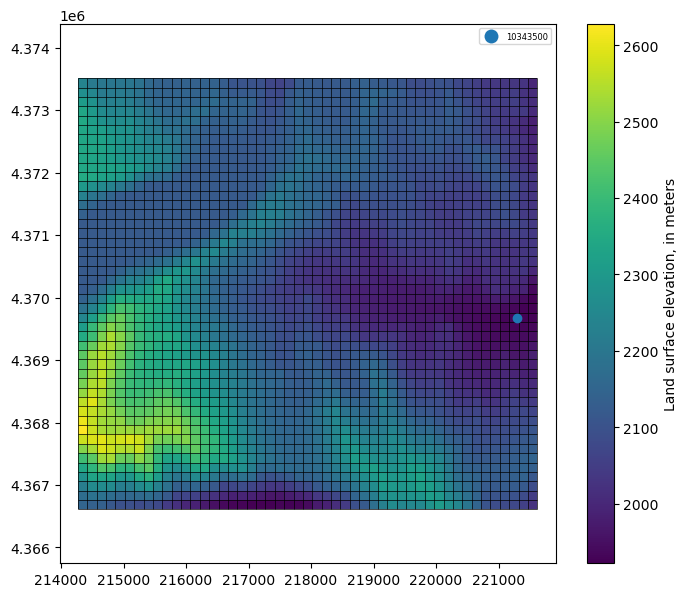

In [28]:
# plot the conditioned DEM
fig, ax = plt.subplots(figsize=(8, 7))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=sgrid, ax=ax)
pc = pmv.plot_array(conditioned_dem)
pmv.plot_grid(color="k", lw=0.5)
sitedf.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize": 6}, zorder=5)
plt.colorbar(pc, label="Land surface elevation, in meters");

Calculate flow directions, flow accumulation and delineate the Sagehen Creek Watershed from the streamgage location

In [29]:
fdobj = dany.FlowDirections(sgrid, conditioned_dem)
fdirs = fdobj.flow_directions()
facc = fdobj.flow_accumulation(as_cells=True)
qx, qy = fdobj.vectors
watershed = fdobj.get_watershed_boundary(sitedf.geometry.values[0])
sgrid._idomain = watershed

Plot up the watershed, flow accumulation, and flow_directions

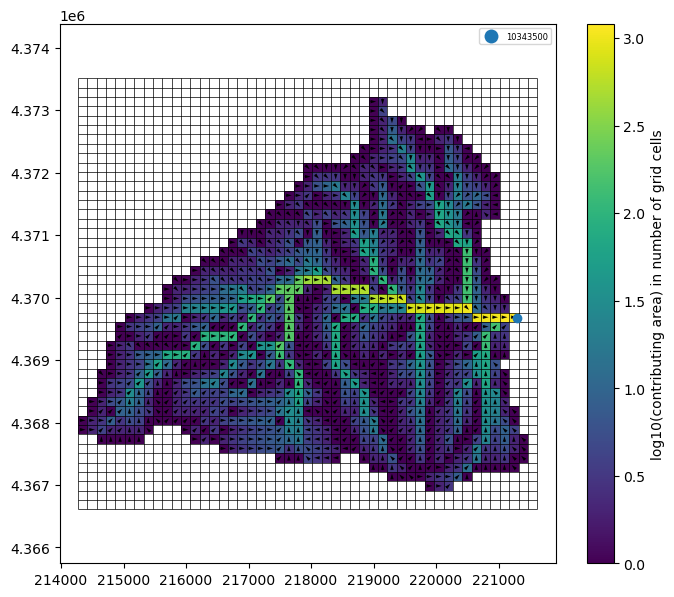

In [30]:
facc[watershed == 0] = np.nan
qx[watershed.ravel() == 0] = np.nan
qy[watershed.ravel() == 0] = np.nan

fig, ax = plt.subplots(figsize=(8, 7))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=sgrid, ax=ax)
pc = pmv.plot_array(np.log10(facc))
pmv.plot_vector(qx, qy)
pmv.plot_grid(color="k", lw=0.5)
sitedf.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize": 6}, zorder=5)
plt.colorbar(pc, label="log10(contributing area) in number of grid cells");

### Generate the stream network using `Sfr2005`

The `D-Any` package includes a class for generating MODFLOW-2005/NWT based stream networks from flow direction and flow accumulation information. The `dany.Sfr2005` class works similarly to the `Sfr6` class and accepts the following input parameters:
   - `modelgrid` : a flopy.discretization.grid object that represents the modeling domain
   - `faobj` : a dany.FlowDirections object that can be used to generate streams

In [31]:
sfr2005 = dany.Sfr2005(sgrid, fdobj)

The `delineate_streams()` method on the `Sfr2005` object allows users to threshold stream cells based on an upslope contributing area. The `delineate_streams()` method accepts one input parameter:
   - `contrib_area`: upslope contributing area threshold. This can either be a single value or an array of values who's shape corresponds to the number of modelgrid nodes.

Try playing with the `contrib_area` variable to see how the stream network changes based on the thresholding factor.

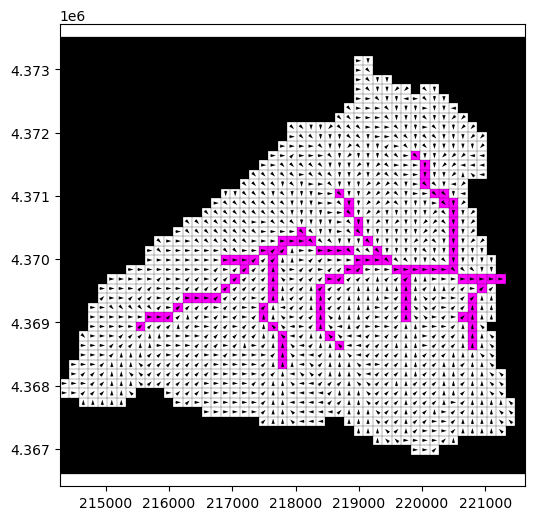

In [32]:
contrib_area = 45  # upslope contributing grid cells in this example
stream_array = sfr2005.delineate_streams(contrib_area)

# plot the flow directions and flow accumulation array
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=sgrid, ax=ax)
pc = pmv.plot_array(stream_array, masked_values=[0], cmap="spring")
pmv.plot_inactive()
pmv.plot_vector(qx, qy)
pmv.plot_grid(color="k", lw=0.2);

#### Creating SFR reach_data inputs for FloPy

The `reach_data` class on the `Sfr2005` package generates a structured numpy array of SFR inputs that can be calculated/estimated from the flow directions and flow accumulation information. The `reach_data` method accepts one optional input parameter.
   - `stream_array`:  optional array of stream locations, if None is provided method uses the internally stored stream array that is produced by delineate_streams()

In [33]:
reach_data = sfr2005.reach_data()
reach_data[0:10]

rec.array([(1689, 0, 34, 23, 1,  1, 225.     , 2133.6272, 0.01779622, 1., 0., 0., 0., 0., 0.,  1, 0),
           (1640, 0, 33, 23, 1,  2, 225.     , 2129.623 , 0.01928494, 1., 0., 0., 0., 0., 0.,  2, 0),
           (1591, 0, 32, 23, 1,  3, 225.     , 2125.284 , 0.02222439, 1., 0., 0., 0., 0., 0.,  3, 0),
           (1542, 0, 31, 23, 1,  4, 318.19806, 2120.2834, 0.02946432, 1., 0., 0., 0., 0., 0.,  4, 0),
           (1492, 0, 30, 22, 1,  5, 318.19806, 2110.908 , 0.02269708, 1., 0., 0., 0., 0., 0.,  5, 0),
           (1442, 0, 29, 21, 1,  6, 225.     , 2103.6858, 0.02957682, 1., 0., 0., 0., 0., 0.,  6, 0),
           (1393, 0, 28, 21, 1,  7, 318.19806, 2097.031 , 0.03042032, 1., 0., 0., 0., 0., 0.,  7, 0),
           (1345, 0, 27, 22, 1,  8, 225.     , 2087.3513, 0.04752387, 1., 0., 0., 0., 0., 0.,  8, 0),
           (1296, 0, 26, 22, 1,  9, 225.     , 2076.6584, 0.03245117, 1., 0., 0., 0., 0., 0.,  9, 0),
           (1247, 0, 25, 22, 1, 10, 225.     , 2069.357 , 0.03705946, 1., 0., 0., 

With this method, the user may need to provide some additional information or make parameter adjustments to have a complete data block for SFR that represents their system.

#### Creating SFR segment_data inputs for FloPy
The `segment_data` class on the `Sfr2005` package generates a recarray of SFR input connectivity from the flow directions and delineated stream information. The `segment_data` method accepts one optional input parameter:
   - `stream_array`:  optional array of stream locations, if None is provided method uses the internally stored stream array that is produced by delineate_streams()

In [34]:
segment_data = sfr2005.segment_data()
segment_data[0:10]

rec.array([( 1, 0, 10, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
           ( 2, 0,  6, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
           ( 3, 0, 13, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
           ( 4, 0,  9, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
           ( 5, 0,  6, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
           ( 6, 0, 21, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
           ( 7, 0, 17, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

With this method, the `segment_data` recarray still needs some additional, user supplied, input data to prior to sending to FloPy. This input data depends on the specific options the user enables for SFR. For more information please see [The online guide to MODFLOW 2005](https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/sfr.html)

## Building pyGSFLOW compatible stream network objects for GSFLOW

`D-Any` also contains methods that return data objects that are compatible with the pyGSFLOW model builder classes. These subroutines apply the same default behavior as pyGSFLOW and store the data in a format that `pygsflow.builder.PrmsBuilder` and `pygsflow.builder.ModflowBuilder` can use.

The following blocks of code will show how to use `PrmsStreams` and `Sfr2005` to get these objects

### Building the `PygsflowCascades` object

The `PygsflowCascades` object stores cascade routining information in a format that `pygsflow.builder.PrmsBuilder` can understand. This object can be used in place of the standard `_Cascades` object that pygsflow produces. This object is created by the `PrmsStreams` class that was shown earlier in this notebook.

Create a new `PrmsStreams` object to start and threshold the stream_array

In [36]:
contrib_area = 45  # upslope contributing grid cells in this example

prms_streams = dany.PrmsStreams(sgrid, fdobj) 
stream_array = prms_streams.delineate_streams(contrib_area)

The `get_pygsflow_builder_object()` method accepts a number of optional parameters, including:
   - `stream_array`:  optional array of stream locations, if None is provided method uses the internally stored stream array that is produced by delineate_streams()
   - `basin_boundary`: optional array of the basin boundary. If this is provided, nodes outside of the active exent of the basin will not have cascades calculated
   - `group_segments`: optional boolean flag. If False, each individual stream cell will be assigned it's own segment number. Default is True and segments are grouped based on continuous reaches between confluences.
   - `many2many`: default is False. If True, many to many cascade routining is calculated. The default behavior is many to one cascades. 

In [39]:
pgsf_cascades = prms_streams.get_pygsflow_builder_object(
    basin_boundary=watershed,
    many2many=False
)
pgsf_cascades.nsegments

101

### Building the `PygsflowStreams` object
The `PygsflowStreams` object stores stream information in a format that `pygsflow.builder.ModflowBuilder` can use. This object holds data that can be used to help generate `SFR` and `UZF` packages. This object is used in place of the standard `_StreamObj` that pygfsflow creates. The `PygsflowStreams` object can be created by the `Sfr2005` object and will apply the standard pygsflow defaults to the input data it produces.

Create a new `Sfr2005` object to begin, and threshold the stream_array.

In [40]:
sfr2005 = dany.Sfr2005(sgrid, fdobj)
stream_array = sfr2005.delineate_streams(contrib_area)

The `get_pygsflow_builder_object()` method accepts a number of optional parameters, including:
   - `reach_data`: optional reach_data recarray, if it is None reach_data will be built
   - `segment_data`: optional segment_data recarray, if the value is None segment_data recarray will be built
   - `irunbnd`: optional uzf irunbnd array, if the value is None irunbnd will be built
   - `apply_defaults`: boolean flag to apply the pygsflow default parameter values for the reach_data and segment_data records. If False, user must 
define SFR reach_data and segment_data values. Defualt is True

In [42]:
pgsf_streams = sfr2005.get_pygsflow_builder_object(
    apply_defaults=True
)

In [43]:
pgsf_streams.reach_data[0:10]

rec.array([(1689, 0, 34, 23, 1,  1, 225.     , 2133.6272, 0.05518433, 1., 1., 0., 0., 0., 0.,  1, 0),
           (1640, 0, 33, 23, 1,  2, 225.     , 2129.623 , 0.05487354, 1., 1., 0., 0., 0., 0.,  2, 0),
           (1591, 0, 32, 23, 1,  3, 225.     , 2125.284 , 0.05437779, 1., 1., 0., 0., 0., 0.,  3, 0),
           (1542, 0, 31, 23, 1,  4, 318.19806, 2120.2834, 0.05359733, 1., 1., 0., 0., 0., 0.,  4, 0),
           (1492, 0, 30, 22, 1,  5, 318.19806, 2110.908 , 0.04941775, 1., 1., 0., 0., 0., 0.,  5, 0),
           (1442, 0, 29, 21, 1,  6, 225.     , 2103.6858, 0.04594929, 1., 1., 0., 0., 0., 0.,  6, 0),
           (1393, 0, 28, 21, 1,  7, 318.19806, 2097.031 , 0.04444029, 1., 1., 0., 0., 0., 0.,  7, 0),
           (1345, 0, 27, 22, 1,  8, 225.     , 2087.3513, 0.04378351, 1., 1., 0., 0., 0., 0.,  8, 0),
           (1296, 0, 26, 22, 1,  9, 225.     , 2076.6584, 0.04092952, 1., 1., 0., 0., 0., 0.,  9, 0),
           (1247, 0, 25, 22, 1, 10, 225.     , 2069.357 , 0.03893683, 1., 1., 0., 

In [44]:
pgsf_streams.segment_data[0:10]

rec.array([( 1, 1, 10, 0, 0, 0, 1., 0., 0., 0., 0.025, 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 0., 0., 0.),
           ( 2, 1,  6, 0, 0, 0, 1., 0., 0., 0., 0.025, 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 0., 0., 0.),
           ( 3, 1, 13, 0, 0, 0, 1., 0., 0., 0., 0.025, 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 0., 0., 0.),
           ( 4, 1,  9, 0, 0, 0, 1., 0., 0., 0., 0.025, 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 0., 0., 0.),
           ( 5, 1,  6, 0, 0, 0, 1., 0., 0., 0., 0.025, 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 0., 0., 0.),
           ( 6, 1, 21, 0, 0, 0, 1., 0., 0., 0., 0.025, 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 0., 0., 0.),
           ( 7, 1, 17, 0, 0, 0, 1., 0., 0., 0., 0.025, 0., 0., 0., 0., 0., 0., 0., 0., 10., 0., 0., 

In [45]:
pgsf_streams.irunbnd

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])